# The rotating cone probelm

Over a unit square a blob of heat is rotated one revolution subject to a high peclet number.  
The evolution of the heat is governed by the advection diffusion equation.  

In Underworld this equation can be numerically approximated with 2 methods ("SUPG" and "SLADE").  
Various numerical parameters can be investigate in the model below.

This classical test problem is taken from J. Donea and A. Huerta, _Finite Element Methods for Flow Problems (2003)_ with an initial field (temperature in this case) given:

    
$
T(x,y,0) = 
\begin{array}{cc}
  \biggl\{ & 
    \begin{array}{cc}
      0.25(1+\cos(\pi X))(1+\cos(\pi Y)) & X^2 + Y^2 < 1, \\
      0 & otherwise, \\
    \end{array}
\end{array}
$

where $(X, Y) = (\space (x-x_0) / \sigma ,\space (y-y_0) / \sigma)\space)$ with $(x_0, y_0)$ as the center of the blob. The domain is a unit square $[-0.5,0.5]x[-0.5,0.5]$ and the rotating velocity is $V(x,y) = (-y,x)$. A static timestep $dt = 2 \pi / 200 $.


In [1]:
import underworld as uw
import underworld.function as fn
import glucifer
import numpy as np

In [ ]:
### run with uw2.8
# get the docker
#!docker pull underworldcode/underworld2:2.8.0b

In [2]:
# numerical parameters
nEls  = 30           # number of elements in x & y
dt    = 2*np.pi/200  # timestep size

In [3]:
def runModel(method, nEls = nEls, dt = dt, elementType='Q1', viz = 1):
    """
    Defines and executes "rotating cone problem" numerical model.
    
    Args
    ----
    method : str, "SUPG" or "SLCN"
        The numerical scheme used to evolve the temperature in time.
    
    nEls : int
        The number of elements of that define the numerical domain, 
        equal in both axis.
    
    dt : float
        The dimensionless timestep size used to integrate the temperature 
        field one time step.
    
    Q1 : str
        The underworld finite element type used to approximate the temperature field 
        
    viz : bool
        Show the initial and final timesteps of the model
        
    Returns
    -------
    maxT : float
        The maximum temperature after one revolution.
    
    avgT : float
        The average temperature after one revolution.
    
    num_t : float
        Wall time (fractional seconds) taken to complete.
    
    steps : int
        The number of discrete time steps to taken to complete.
    """
    
    # default model parameters
    sigma = 0.2          # width of blob
    x_0   = (1./6, 1./6) # position of blob
    kappa = 1e-6         # thermal diffusion (entire domain)
    # unit 2D mesh max/min coords
    minCoord = [-0.5,-0.5]
    maxCoord = [0.5,0.5]
    
    # define a quick reporting function
    def reportMetics(maxT, avgT):
        if uw.mpi.rank == 0:
            s =  "max temperature = {:.4f} / ".format(maxT)
            s += "avg. temperature = {:.4f}".format(avgT)
            print(s)
            
    mesh = uw.mesh.FeMesh_Cartesian(elementType = elementType, 
                                    elementRes  = (nEls,nEls),
                                    minCoord    = minCoord,
                                    maxCoord    = maxCoord )

    tField = mesh.add_variable(1)
    vField = mesh.add_variable(2)

    all_walls = mesh.specialSets["AllWalls_VertexSet"]

    fig = glucifer.Figure()
    fig.VectorArrows(mesh,vField)
#     fig.Mesh(mesh)
    fig.Surface(mesh,tField, valueRange=[0.,1.]);

    # functions to define the cosine hill
    fn_X = (fn.input()[0]-x_0[0])/sigma
    fn_Y = (fn.input()[1]-x_0[1])/sigma
    
    fn_inside = ( fn.math.pow(fn_X,2.) + fn.math.pow(fn_Y,2.) ) < 1.
    fn_hill   = 0.25 * ( 1.+fn.math.cos(np.pi*fn_X) ) * ( 1.+fn.math.cos(np.pi*fn_Y) )

    fn_ic = fn.branching.conditional([(fn_inside, fn_hill ), 
                                      (True     , 0.)])
    
    # evaluate the function over the mesh and store on the tField
    tField.data[:] = fn_ic.evaluate(mesh)

    x_vel = -1.*uw.function.coord()[1]
    y_vel =  1.*uw.function.coord()[0]

    vField.data[:,0] = x_vel.evaluate(mesh).reshape(-1)
    vField.data[:,1] = y_vel.evaluate(mesh).reshape(-1)

    fn_K = uw.function.misc.constant(kappa)

    if viz: fig.show()

    measureT = fn.view.min_max(tField,fn_auxiliary=fn.input())
    measureT.evaluate(mesh);
    maxT     = measureT.max_global()
    
    intT,vol = mesh.integrate(fn=(tField,1.))
    avgT     = intT/vol

    dbc = uw.conditions.DirichletCondition(variable=tField,
                                           indexSetsPerDof=all_walls)

    # extra variable needed with supg
    tDotField = None
    if method == "SUPG":
        tDotField = mesh.add_variable( nodeDofCount=1, dataType='double')
        
    system = uw.systems.AdvectionDiffusion( phiField       = tField,
                                            method         = method,
                                            phiDotField    = tDotField,
                                            velocityField  = vField,
                                            fn_diffusivity = fn_K,
                                            conditions     = [dbc], kwages=None )
    
    reportMetics(maxT, avgT)
    
    from timeit import default_timer as timer

    t0    = timer()
    num_t = 0
    time  = 0
    steps = 0

    if dt < 0:
        dt = system.get_max_dt()
        
    while time<2.*np.pi:

        system.integrate(dt)

        time  += dt
        steps += 1
        fig.save_image("{}/{}".format(method, str(steps).zfill(4)))

    num_t = timer()-t0
    if uw.mpi.rank == 0:
        print("{} method, wall time {:.4e}, number of interations {} dt {:.4e}".format(
            system.method, num_t, steps, dt))

    if viz: fig.show()

    measureT = fn.view.min_max(tField,fn_auxiliary=fn.input())
    measureT.evaluate(mesh);
    maxT     = measureT.max_global()

    intT,vol = mesh.integrate(fn=(tField,1.))
    avgT     = intT/vol

    reportMetics(maxT, avgT)
        
    return maxT, avgT, num_t, steps, nEls, dt


In [4]:
!mkdir SLCN SUPG


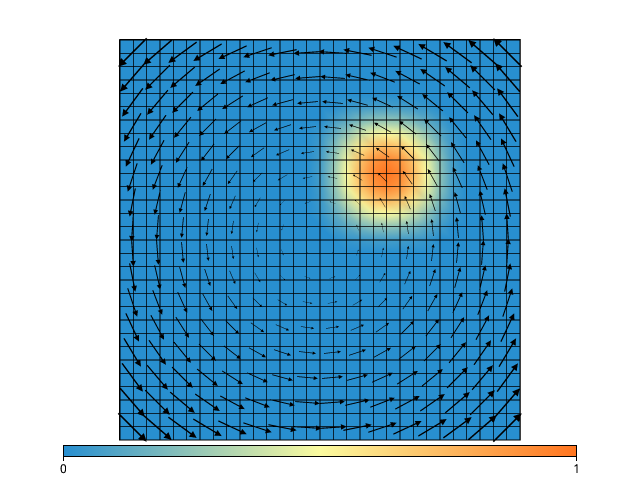

max temperature = 1.0000 / avg. temperature = 0.0398
SLCN method, wall time 3.2944e+01, number of interations 201 dt 3.1416e-02



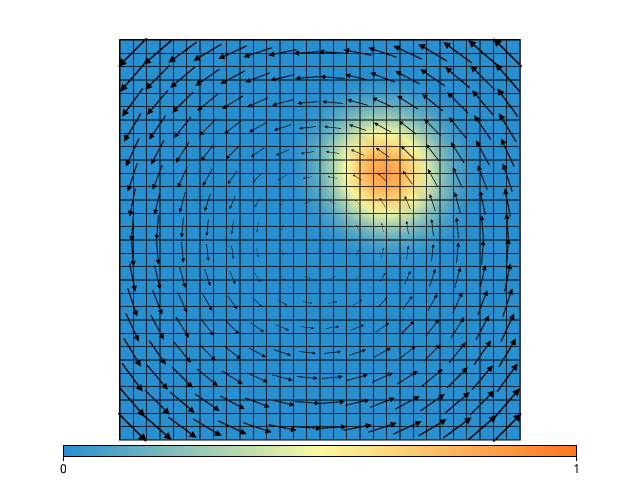

max temperature = 0.8511 / avg. temperature = 0.0401



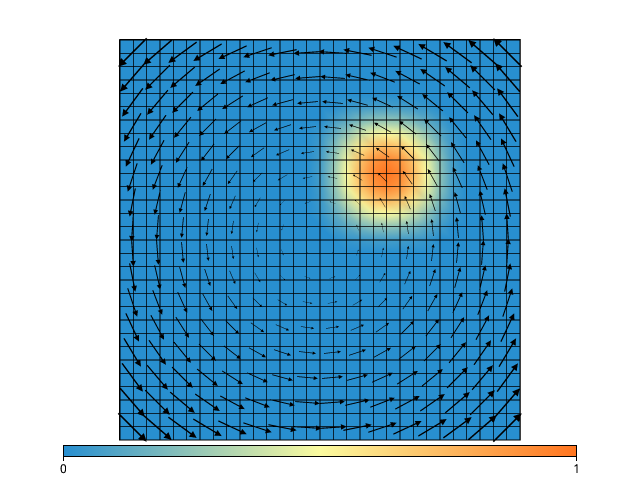

max temperature = 1.0000 / avg. temperature = 0.0398
SUPG method, wall time 3.9568e+01, number of interations 201 dt 3.1416e-02



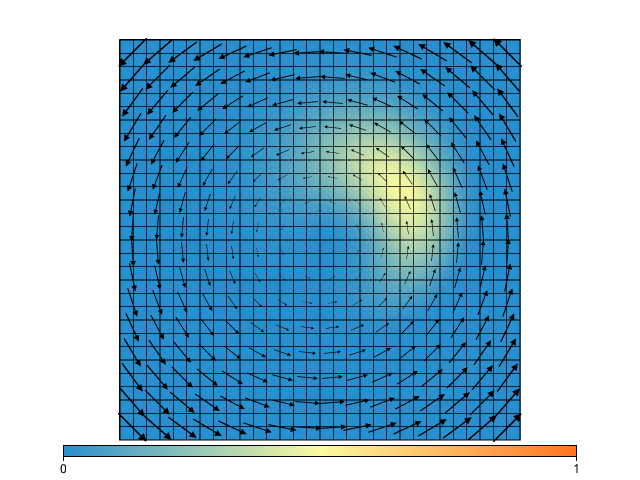

max temperature = 0.4956 / avg. temperature = 0.0399


In [5]:
results_slcn = runModel("SLCN", nEls = nEls, dt = dt, viz = 1)
results_supg = runModel("SUPG", nEls = nEls, dt = dt, viz = 1)

In [6]:
# test the max temperature and avg. temperature iff nEls == 30
# against expected results for 1 proc
if uw.mpi.rank == 0:
    if results_supg[4] == 30:
        expected = [0.4956, 0.0399]
        if not np.allclose([results_supg[0],results_supg[1]], 
                            expected, rtol=1e-3):
            raise RuntimeError("Failed SUPG test")
    
    if results_slcn[4] ==30:
        expected = [0.8511, 0.0401]
        if not np.allclose([results_slcn[0], results_slcn[1]],
                            expected, rtol=1e-3):
            raise RuntimeError("Failed SUPG test")        

In [7]:
!mv SLCN SUPG /home/jovyan/workspace/models/advection_cosinehill/